# Estimating reference expression signatures of cell types

## liver reference, lowQ excluded

## Outline

The **cell2location** workflow consists of three sections:

I. Estimating reference expression signatures of cell types (1/3, this notebook):

1. [Loading single cell reference data](#1.-Loading-single-cell-reference-data)
2. [Reduce the number of genes by discarding lowly expressed genes](#2.-Reduce-the-number-of-genes-by-discarding-lowly-expressed-genes)
3. [Exploring the data: show UMAP of cells](#3.-Show-UMAP-of-cells)
4. [Estimating expression signatures](#4.-Estimating-expression-signatures)
5. [Additional quality control: removing technical effects and performing standard scanpy single cell analysis workflow](#5.-Additional-quality-control:-removing-technical-effects-and-performing-standard-scanpy-single-cell-analysis-workflow)

II. Spatially mapping cell types (2/3)

III. Results and downstream analysis (3/3)

![**cell2location** workflow](https://raw.githubusercontent.com/BayraktarLab/cell2location/master/docs/images/FigS1_cell2location_workflow.png)



## Loading packages

First, we need to load the relevant packages. Regression model for estimating expression signatures of cell types cell2location is written in pytorch. While the package works on both GPU and CPU, using the GPU shortens the computation time by ~8 times to just a few minutes.

In [1]:
import sys,os

#if branch is stable, will install via pypi, else will install from source
#branch = "pyro-cell2location"
#user = "vitkl"
#IN_COLAB = "google.colab" in sys.modules

#if IN_COLAB and branch == "stable":
#    !pip install --quiet scvi-tools[tutorials]
#elif IN_COLAB and branch != "stable":
#    !pip install --quiet --upgrade jsonschema
#    !pip install --quiet git+https://github.com/$user/scvi-tools@$branch#egg=scvi-tools[tutorials]
        
#import sys
#if not IN_COLAB:
# sys.path.insert(1, '/home/jupyter/cell2location/')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

import torch
#torch.cuda.set_device('cuda:1')
torch.cuda.is_available(), torch.cuda.current_device(), torch.cuda.device_count()

(True, 0, 1)

## 1. Loading single cell reference data <a name="1.-Loading-single-cell-reference-data"></a>

In [2]:
sc_data_folder = '/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/c2l_scRNA_references/'
sc_data_h5ad = 'PAN.A01.v01.c2l_reference.v2.subsetTH.exclude_lowQ.addTECs.keep_fetal_TECs.h5ad'
results_folder = '/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/c2l_results/'

if not os.path.exists(results_folder):
    os.mkdir(results_folder)
scvi_run_name = f'{results_folder}signatures_{sc_data_h5ad.rstrip(".h5ad")}'

In [3]:
scvi_run_name = f'{results_folder}signatures_{sc_data_h5ad.rstrip(".h5ad")}'

Now, we load the pre-processed snRNAseq reference. Scanpy website has tutorials covering how to import other formats.

In [4]:
## snRNA reference (raw counts)
adata = anndata.read_h5ad(sc_data_folder + sc_data_h5ad)

In [5]:
# remove "/" from cell types to avoid anndata save issues
from re import sub
adata.obs['anno_c2l'] = [sub('/', '_', i) for i in adata.obs['anno_c2l']]

In [6]:
adata.layers, adata.raw

(Layers with keys: , None)

In [7]:
adata.obs

,method,donor,Sample.lanes,anno_c2l,organ,age
FCAImmP7277564-AGAGTGGTCTCATTCA-0,3GEX,F30,FCAImmP7277564,TREG,TH,14.0
FCAImmP7277564-CCGTACTGTCTTGTCC-0,3GEX,F30,FCAImmP7277564,CD8AA,TH,14.0
FCAImmP7277564-CAACCTCAGCTACCGC-0,3GEX,F30,FCAImmP7277564,CYCLING_B,TH,14.0
FCAImmP7277564-GTGAAGGTCAAACGGG-0,3GEX,F30,FCAImmP7277564,DC1,TH,14.0
FCAImmP7277564-CGACCTTCAAAGTGCG-0,3GEX,F30,FCAImmP7277564,DP(P)_T,TH,14.0
...,...,...,...,...,...,...
Human_colon_16S7985397-CTGCTGTTCACCGTAA-1,5GEX,F74,nan,cTEC,TH,NaN
Human_colon_16S7985397-GATCGCGTCTGTCTCG-1,5GEX,F74,nan,cTEC,TH,NaN
Human_colon_16S7985397-GGACGTCTCTATGTGG-1,5GEX,F74,nan,cTEC,TH,NaN
Human_colon_16S7985397-GGATGTTGTCAAAGAT-1,5GEX,F74,nan,mcTEC,TH,NaN


In [8]:
# checking that data is integer counts
adata.X.data

array([  1., 128.,   2., ...,   1.,   1.,   1.], dtype=float32)

## 2. Reduce the number of genes by discarding lowly expressed genes <a name="2.-Reduce-the-number-of-genes-by-discarding-lowly-expressed-genes"></a>

This is performed using 2 cut-off to remove as many lowly expressed genes as possible and yet avoid highly variable gene selection (HVG) which is prone to deleting markers of rare populations:

1. Include all genes expressed by at least 3% of cells (`cell_count_cutoff2`)
2. Include genes expressed by at least 0.02% of cells (`cell_count_cutoff`) when they have high counts in non-zero cells (`nonz_mean_cutoff`)

We prefer this way of selecting genes because step 2 allows retaining genes expressed by rare cell populations but at high levels, whereas standard HVG selection methods can filter out such genes due to their low global mean and variance.

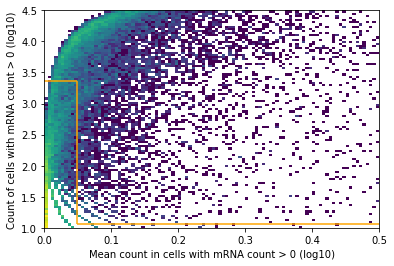

In [9]:
# remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata.var['n_cells'] = np.array((adata.X > 0).sum(0)).flatten()
adata.var['nonz_mean'] = np.array(adata.X.sum(0)).flatten() \
/ adata.var['n_cells']

plt.hist2d(np.log10(adata.var['nonz_mean']),
           np.log10(adata.var['n_cells']), bins=100,
           norm=mpl.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);

nonz_mean_cutoff = np.log10(1.12) # cut off for expression in non-zero cells 
cell_count_cutoff = np.log10(adata.shape[0] * 0.0001) # cut off percentage for cells with higher expression
cell_count_cutoff2 = np.log10(adata.shape[0] * 0.02)# cut off percentage for cells with small expression

plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color = 'orange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color = 'orange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color = 'orange');
plt.xlabel('Mean count in cells with mRNA count > 0 (log10)');
plt.ylabel('Count of cells with mRNA count > 0 (log10)');

Show the number of selected cells and genes:

In [10]:
adata[:,(np.array(np.log10(adata.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata.var['n_cells']) > cell_count_cutoff)].shape

(113904, 15850)

Filter the object:

In [11]:
# select genes based on mean expression in non-zero cells
adata = adata[:,(np.array(np.log10(adata.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata.var['n_cells']) > cell_count_cutoff)].copy()

Add counts matrix as `adata.raw` 

In [12]:
adata.var

,GeneID-0,GeneName-0,GeneID-1,GeneName-1,n_cells,nonz_mean
A1BG,ENSG00000121410,A1BG,ENSG00000121410,A1BG,31107,1.446202
A2M,ENSG00000175899,A2M,ENSG00000175899,A2M,2807,2.871037
A2ML1,ENSG00000166535,A2ML1,ENSG00000166535,A2ML1,139,1.223022
A4GALT,ENSG00000128274,A4GALT,ENSG00000128274,A4GALT,458,1.360262
AAAS,ENSG00000094914,AAAS,ENSG00000094914,AAAS,29569,1.416855
...,...,...,...,...,...,...
ZXDC,ENSG00000070476,ZXDC,ENSG00000070476,ZXDC,5599,1.070906
ZYG11B,ENSG00000162378,ZYG11B,ENSG00000162378,ZYG11B,10264,1.112919
ZYX,ENSG00000159840,ZYX,ENSG00000159840,ZYX,34956,2.045743
ZZEF1,ENSG00000074755,ZZEF1,ENSG00000074755,ZZEF1,13229,1.146799


## 4. Estimating expression signatures  <a name="4.-Estimating-expression-signatures"></a> 

### Brief description of the model

**Model-based estimation of reference expression signatures of cell types $g_{f,g}$ using a regularised Negative Binomial regression.** This model robustly derives reference expression signatures of cell types $g_{f,g}$ using the data composed of multiple batches $e=\{1..E\}$ and technologies $t=\{1..T\}$. Adapting the assumptions of a range of computational methods for scRNA-seq, we assume that the expression count matrix follows a Negative Binomial distribution with unobserved expression levels (rates) $\mu_{c,g}$ and a gene-specific over-dispersion $\alpha_g$. We model $\mu_{c,g}$ as a linear function of reference cell type signatures and technical effects:
- $e_e$ denotes a multiplicative global scaling parameter between experiments/batches $e$ (e.g. differences in sequencing depth);
- $t_{t,g}$ accounts for multiplicative gene-specific difference in sensitivity between technologies; 
- $b_{e,g}$ accounts for additive background shift of each gene in each experiment $e$ (proxy for free-floating RNA).

### Training the model

Here we show how to perform the training of this model wrapped into a singe pipeline function call, how to assess the quality of this model and extract reference signatures of cell types for use with cell2location:

In [13]:
adata.obs['anno_c2l'].value_counts()[::-1][0:20]

IMMATURE_B                               20
SMOOTH_MUSCLE                            20
HSC_MPP                                  26
MACROPHAGE_PERI                          26
LATE_ERY                                 27
FIBROBLAST_VI                            27
ELP                                      29
EOSINOPHIL_BASOPHIL                      32
GMP                                      34
LARGE_PRE_B                              35
CMP                                      36
PRE_PRO_B                                37
MONOCYTE_I_CXCR4                         47
mTEC(III)                                49
FIBROBLAST_X                             49
CYCLING_DC                               52
EARLY_ERY                                54
LATE_PRO_B                               55
MESENCHYMAL_LYMPHOID_TISSUE_ORGANISER    56
SMALL_PRE_B                              58
Name: anno_c2l, dtype: int64

In [14]:
# prepare anndata for scVI model
scvi.data.setup_anndata(adata=adata, batch_key='Sample.lanes', labels_key='anno_c2l',
                        categorical_covariate_keys=['method', 'donor']
                       )
scvi.data.view_anndata_setup(adata)

INFO     Using batches from adata.obs["Sample.lanes"]                                        
INFO     Using labels from adata.obs["anno_c2l"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 113904 cells, 15850 vars, 33      
         batches, 74 labels, and 0 proteins. Also registered 2 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


Anndata setup with scvi-tools version 0.13.0.

              Data Summary               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃             Data             ┃ Count  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│            Cells             │ 113904 │
│             Vars             │ 15850  │
│            Labels            │   74   │
│           Batches            │   33   │
│           Proteins           │   0    │
│ Extra Categorical Covariates │   2    │
│ Extra Continuous Covariates  │   0    │
└──────────────────────────────┴────────┘

                    SCVI Data Registry                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃          scvi-tools Location           ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │                adata.X                 │
│ batch_indices │        adata.obs['_scvi_batch']        │
│ local_l_mean  │    adata.obs['_scvi_local_l_mean']     │
│  local_l_var  │     adata.obs['_scvi_local_l_var']     │
│    labels     │       adata.obs['_scvi_labels']        │
│   cat_covs    │ adata.obsm['_scvi_extra_categoricals'] │
└───────────────┴────────────────────────────────────────┘

                                   Label Categories                                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃              Categories               ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['anno_c2l'] │              ABT(ENTRY)               │          0          │
│                       │                  B1                   │          1          │
│                       │                 CD4+T                 │          2          │
│                       │                 CD8+T                 │          3          │
│                       │                 CD8AA                 │          4          │
│                       │              CHONDROCYTE              │          5          │
│                       │                  CMP                  │          6          │
│                       │               CYCLING_B               │          7          │
│                       │              CYCLING_DC               │          8          │
│                       │         CYCLING_FIBROBLAST_I          │          9          │
│                       │              CYCLING_NK               │         10          │
│                       │               CYCLING_T               │         11          │
│                       │                  DC1                  │         12          │
│                       │                  DC2                  │         13          │
│                       │                DN(P)_T                │         14          │
│                       │                DN(Q)_T                │         15          │
│                       │              DN(early)_T              │         16          │
│                       │                DP(P)_T                │         17          │
│                       │                DP(Q)_T                │         18          │
│                       │               EARLY_ERY               │         19          │
│                       │                  ELP                  │         20          │
│                       │             ENDOTHELIUM_I             │         21          │
│                       │            ENDOTHELIUM_II             │         22          │
│                       │          EOSINOPHIL_BASOPHIL          │         23          │
│                       │             FIBROBLAST_I              │         24          │
│                       │             FIBROBLAST_VI             │         25          │
│                       │            FIBROBLAST_VII             │         26          │
│                       │             FIBROBLAST_X              │         27          │
│                       │             FIBROBLAST_XI             │         28          │
│                       │            FIBROBLAST_XII             │         29          │
│                       │            FIBROBLAST_XIV             │         30          │
│                       │            FIBROBLAST_XVII            │         31          │
│                       │                 GLIAL                 │         32          │
│                       │                  GMP                  │         33          │
│                       │                HSC_MPP                │         34          │
│                       │                 ILC3                  │         35          │
│                       │              IMMATURE_B               │         36          │
│                       │             KERATINOCYTE              │         37          │
│                       │              LARGE_PRE_B              │         38          │
│                       │               LATE_ERY                │         39          │
│                       │              LATE_PRO_B               │         40          │
│                       │               

                          Batch Categories                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample.lanes'] │ FCAImmP7179369 │          0          │
│                           │ FCAImmP7179370 │          1          │
│                           │ FCAImmP7198432 │          2          │
│                           │ FCAImmP7198634 │          3          │
│                           │ FCAImmP7198635 │          4          │
│                           │ FCAImmP7277556 │          5          │
│                           │ FCAImmP7277564 │          6          │
│                           │ FCAImmP7277565 │          7          │
│                           │ FCAImmP7292030 │          8          │
│                           │ FCAImmP7292034 │          9          │
│                           │ FCAImmP7316898 │         10          │
│                           │ FCAImmP7316899 │         11          │
│                           │ FCAImmP7528283 │         12          │
│                           │ FCAImmP7528284 │         13          │
│                           │ FCAImmP7528285 │         14          │
│                           │ FCAImmP7528294 │         15          │
│                           │ FCAImmP7555851 │         16          │
│                           │ FCAImmP7555852 │         17          │
│                           │ FCAImmP7555860 │         18          │
│                           │ FCAImmP7555861 │         19          │
│                           │ FCAImmP7579218 │         20          │
│                           │ FCAImmP7579219 │         21          │
│                           │ FCAImmP7579230 │         22          │
│                           │ FCAImmP7579231 │         23          │
│                           │ FCAImmP7851890 │         24          │
│                           │ FCAImmP7851891 │         25          │
│                           │ FCAImmP7851892 │         26          │
│                           │ FCAImmP7851893 │         27          │
│                           │ FCAImmP7851894 │         28          │
│                           │ FCAImmP7851895 │         29          │
│                           │ FCAImmP7851896 │         30          │
│                           │ FCAImmP7851897 │         31          │
│                           │      nan       │         32          │
└───────────────────────────┴────────────────┴─────────────────────┘

               Extra Categorical Variables                
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['method'] │    3GEX    │          0          │
│                     │    5GEX    │          1          │
│                     │            │                     │
│ adata.obs['donor']  │    C34     │          0          │
│                     │    C40     │          1          │
│                     │    C41     │          2          │
│                     │    F21     │          3          │
│                     │    F22     │          4          │
│                     │    F23     │          5          │
│                     │    F29     │          6          │
│                     │    F30     │          7          │
│                     │    F32     │          8          │
│                     │    F38     │          9          │
│                     │    F41     │         10          │
│                     │    F45     │         11          │
│                     │    F64     │         12          │
│                     │    F67     │         13          │
│                     │    F74     │         14          │
│                     │    F83     │         15          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████| 999/999 [00:20<00:00, 47.65it/s]


/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'anno_c2l' as categorical


'/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/c2l_results/signatures_PAN.A01.v01.c2l_reference.v2.subsetTH.exclude_lowQ.addTECs.keep_fetal_TECssignatures_200epochs/sc.h5ad'

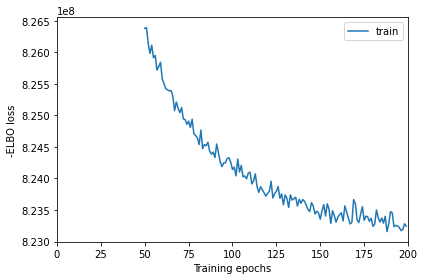

In [15]:
# create and train the model
import pyro
from cell2location.models import RegressionModel
mod = RegressionModel(
    adata,
    #amortised=True, encoder_mode="single",
    #encoder_kwargs={'dropout_rate': 0.1}
) 

mod.train(max_epochs=200, 
          batch_size=2500, 
          train_size=1,
          plan_kwargs={'optim': pyro.optim.Adam(optim_args={'lr': 0.002})},
          use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(50)

# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata = mod.export_posterior(
    adata, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{scvi_run_name}signatures_200epochs", overwrite=True)
# can be loaded later like this:
# mod = scvi.external.cell2location.RegressionModel.load(f"{scvi_run_name}", adata)

# Save anndata object with results
adata_file = f"{scvi_run_name}signatures_200epochs/sc.h5ad"
adata.write(adata_file)
adata_file

In [ ]:
scvi_run_name

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████| 999/999 [00:17<00:00, 55.64it/s]


'/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/c2l_results/signatures_PAN.A01.v01.c2l_reference.v2.subsetTH.exclude_lowQ.addTECs.keep_fetal_TECs_400epochs/sc.h5ad'

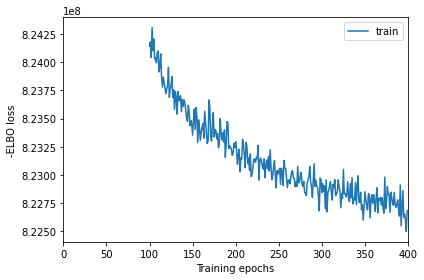

In [17]:
# scvi_run_name = f'{results_folder}signatures_400epochs'

mod.train(max_epochs=200, 
          batch_size=2500, 
          train_size=1,
          plan_kwargs={'optim': pyro.optim.Adam(optim_args={'lr': 0.002})},
          use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(100)

# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata = mod.export_posterior(
    adata, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{scvi_run_name}_400epochs", overwrite=True)
# can be loaded later like this:
# mod = scvi.external.cell2location.RegressionModel.load(f"{scvi_run_name}", adata)

# Save anndata object with results
adata_file = f"{scvi_run_name}_400epochs/sc.h5ad"
adata.write(adata_file)
adata_file

In [ ]:
mod.plot_history(100)

Examine QC plots

1. Reconstruction accuracy to assess if there are any issues with inference.

2. The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

In [ ]:
mod.plot_QC()

Modules and their versions used for this analysis

In [ ]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass